### Importing Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [117]:
df_train=pd.read_csv('BTC-USD Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
df=df_train.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
1,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
3,2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
4,2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


 I'm gonna use close for prediction but can use other also

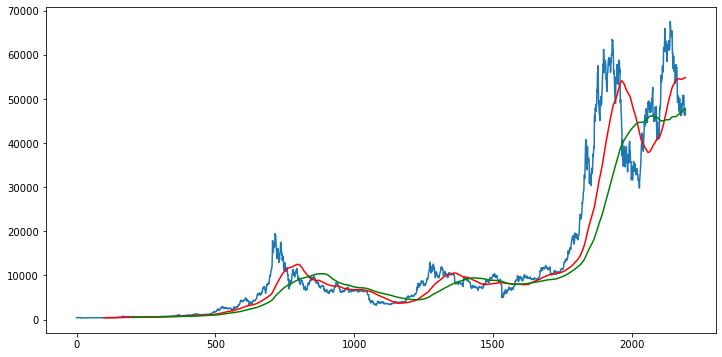

In [12]:
# Moving Average
ma100=df.Close.rolling(100).mean()
ma200=df.Close.rolling(200).mean()

#Plotting moving averages
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')
plt.show()

Graph is going below 200 moving average. so, It may further decrease from this point

### Data Preprocessing

In [30]:
#Splitting data into 70:30 ratio

train_data=pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
test_data=pd.DataFrame(df['Close'][int(len(df)*0.70) : int(len(df))])

print(train_data.shape,'',test_data.shape)

(1535, 1)  (658, 1)


In [31]:
#Feature Scaling

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
train_data_std=scaler.fit_transform(train_data)

In [62]:
# Creating a datastructure with 60 timestamps

x_train=[]
y_train=[]
for i in range (60,train_data_std.shape[0]):
    x_train.append(train_data_std[i-60:i,0])
    y_train.append(train_data_std[i,0])
    
x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape, y_train.shape

((1475, 60), (1475,))

In [64]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1475, 60, 1)

### LSTM Model Building

In [33]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [65]:
#Initialising the RNN
model=Sequential()

#Adding Layers
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
    
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

#adding output layer
model.add(Dense(units=1))

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_13 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_14 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

In [67]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
47/47 [==============================] - 15s 182ms/step - loss: 0.0314
Epoch 2/50
47/47 [==============================] - 8s 168ms/step - loss: 0.0074
Epoch 3/50
47/47 [==============================] - 8s 171ms/step - loss: 0.0063
Epoch 4/50
47/47 [==============================] - 8s 180ms/step - loss: 0.0070
Epoch 5/50
47/47 [==============================] - 9s 185ms/step - loss: 0.0061
Epoch 6/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0055
Epoch 7/50
47/47 [==============================] - 8s 166ms/step - loss: 0.0053
Epoch 8/50
47/47 [==============================] - 8s 170ms/step - loss: 0.0043
Epoch 9/50
47/47 [==============================] - 8s 171ms/step - loss: 0.0044
Epoch 10/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0046
Epoch 11/50
47/47 [==============================] - 9s 197ms/step - loss: 0.0044
Epoch 12/50
47/47 [==============================] - 9s 192ms/step - loss: 0.0040
Epoch 13/50
47/47 [=====

### Validating the data

In [137]:
# To validate we need past 60 days data.so,

past_60_days = train_data.tail(60)
final_df = past_60_days.append(test_data,ignore_index = True)
final_df.head()

,Close
0,8807.010742
1,8723.786133
2,8929.038086
3,8942.808594
4,8706.245117


In [138]:
final_df_std = scaler.fit_transform(final_df)
final_df_std.shape

(718, 1)

In [141]:
x_test = []
y_test = []

for i in range (60, final_df_std.shape[0]):
    x_test.append(final_df_std[i-60:i,0])
    y_test.append(final_df_std[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((658, 60), (658,))

In [142]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(658, 60, 1)

In [143]:
y_pred = model.predict(x_test)

In [144]:
scale_factor = 1/scaler.scale_

In [145]:
y_pred = y_pred*scale_factor
y_pred[0:3]

array([[6775.67199185],
       [6634.57014487],
       [6473.38844299]])

In [146]:
y_test = y_test*scale_factor
y_test[0:3]

array([421.526855,  43.691894, 254.841309])

In [147]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,y_pred))

4605.716293738245

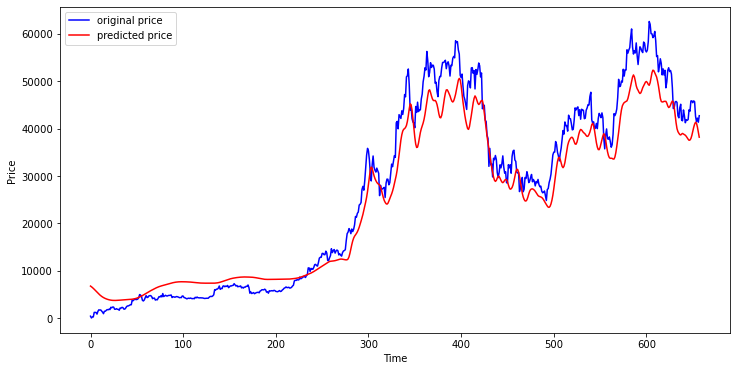

In [149]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b' , label = 'original price')
plt.plot(y_pred, 'r' , label = 'predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Actual Test Data

In [118]:
# importing test data

df_test=pd.read_csv('BTC-USD Out of Time Testing 1st Jan 2022 to 4th Feb 2022.csv')

In [152]:
df1 = pd.DataFrame(df_test['Close'])

In [162]:
df1.shape

(35, 1)

In [153]:
# as past 60 values needed to predict 

past_60_days = final_df.tail(60)
test_final = past_60_days.append(df1, ignore_index = True)
test_final_std = scaler.fit_transform(test_final)
test_final_std.shape

(95, 1)

In [157]:
x_test = []

for i in range (60, test_final_std.shape[0]):
    x_test.append(test_final_std[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price)

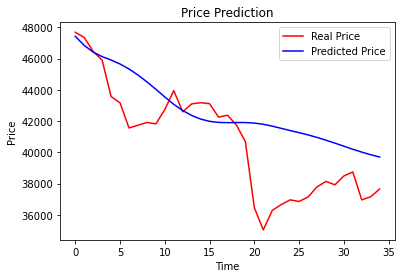

In [159]:
# Visualising the results
plt.plot(df1.values, color = 'red', label = 'Real Price')
plt.plot(pred_price, color = 'blue', label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [164]:
math.sqrt(mean_squared_error(df1.values,pred_price))

2869.044179935152